In [1]:
import tensorflow as tf
import numpy as np
import inceptionv3
from utils import *
from defense import *

In [2]:
sess = tf.Session()

# Image and target class

Choose what you want here.

In [3]:
orig = load_image('cat.jpg')
TARGET = 924 # guacamole

# Classifier

In [4]:
x = tf.placeholder(tf.float32, (299, 299, 3))
x_expanded = tf.expand_dims(x, axis=0)
logits, preds = inceptionv3.model(sess, x_expanded)

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from data/inception_v3.ckpt


In [5]:
probs = tf.nn.softmax(logits)
classify = make_classify(sess, x, probs)

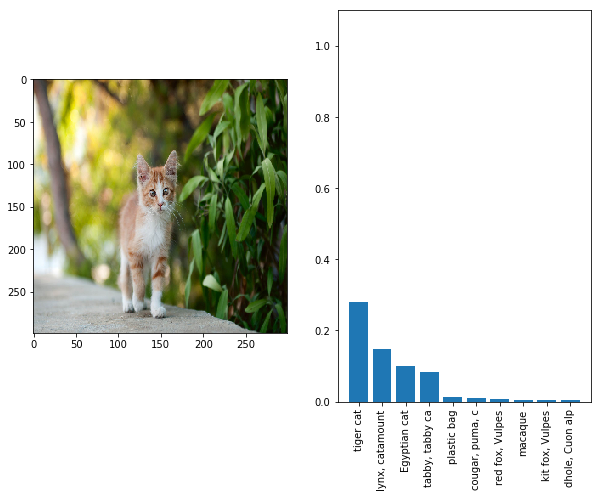

In [6]:
classify(orig, target_class=TARGET)

# Failed attack (attempting to transfer)

In [7]:
l2_x = tf.placeholder(tf.float32, (299, 299, 3))
l2_orig = tf.placeholder(tf.float32, (299, 299, 3))
normalized_l2_loss = tf.nn.l2_loss(l2_orig - l2_x) / tf.nn.l2_loss(l2_orig)

xent = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot(TARGET, 1000))
lam = tf.placeholder(tf.float32, ())
loss = xent + lam * normalized_l2_loss
grad, = tf.gradients(loss, x)

In [8]:
# PGD

LAM = 1.0
LR = 0.1

adv = np.copy(orig)
for i in range(10):
    g, l2, p = sess.run([grad, normalized_l2_loss, preds], {x: adv, lam: LAM, l2_x: adv, l2_orig: orig})
    print('step %d, l2=%f, pred=%d' % (i, l2, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, 0, 1)

step 0, l2=0.000000, pred=282
step 1, l2=0.000056, pred=277
step 2, l2=0.000075, pred=231
step 3, l2=0.000095, pred=263
step 4, l2=0.000102, pred=274
step 5, l2=0.000113, pred=282
step 6, l2=0.000121, pred=924
step 7, l2=0.000136, pred=924
step 8, l2=0.000143, pred=924
step 9, l2=0.000153, pred=924


In [9]:
cropped_xs = defend_crop(x)
cropped_logits, cropped_preds = inceptionv3.model(sess, cropped_xs)

INFO:tensorflow:Scale of 0 disables regularizer.


In [10]:
cropped_probs = tf.reduce_mean(tf.nn.softmax(cropped_logits), axis=0, keepdims=True)
cropped_classify = make_classify(sess, x, cropped_probs)

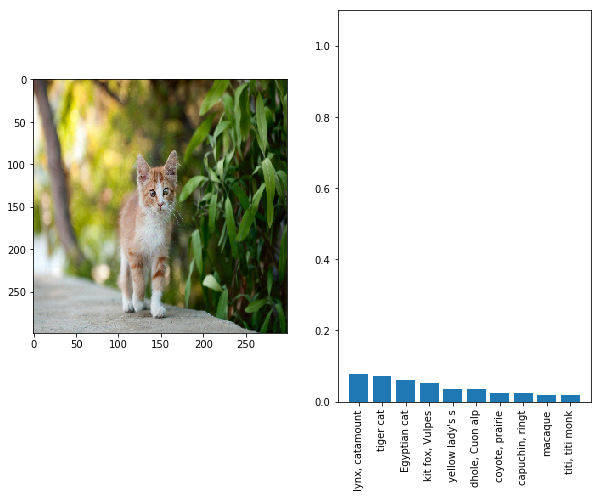

In [11]:
cropped_classify(adv, target_class=TARGET)

# Attack

Using EOT.

In [12]:
cropped_labels = tf.tile(tf.expand_dims(tf.one_hot(TARGET, 1000), axis=0), (cropped_logits.shape[0], 1))
cropped_xent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=cropped_logits, labels=cropped_labels))
cropped_loss = cropped_xent + lam * normalized_l2_loss
cropped_grad, = tf.gradients(cropped_loss, x)

In [13]:
# PGD

LAM = 1.0
LR = 0.1

adv = np.copy(orig)
for i in range(50):
    g, l2, p = sess.run([cropped_grad, normalized_l2_loss, cropped_preds], {x: adv, lam: LAM, l2_x: adv, l2_orig: orig})
    if i % 10 == 0:
        print('step %d, l2=%f, preds=%s' % (i, l2, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, 0, 1)

step 0, l2=0.000000, preds=[335 282 373 287 371 336 364 998 287 287 282 272 287  47 986 282 280 278
 282 384 373 278 278 274 285  95 282 384 285 278]
step 10, l2=0.000093, preds=[924 924 924 282 287  46 986 287 924 924 382 924 924 924 924 956 924 924
 378 943 287 924 924 287 939 924 924 287 924 924]
step 20, l2=0.000168, preds=[923 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924
 924 924 924 924 924 924 924 924 924 934 924 924]
step 30, l2=0.000185, preds=[924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924
 924 924 924 924 924 924 924 924 924 924 924 924]
step 40, l2=0.000195, preds=[924 924 924 924 924 924 924 924 924 924 924 924 965 924 924 924 924 924
 924 924 924 965 924 924 924 924 924 924 924 924]


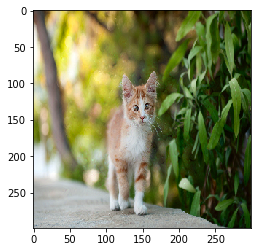

In [14]:
plt.imshow(adv)

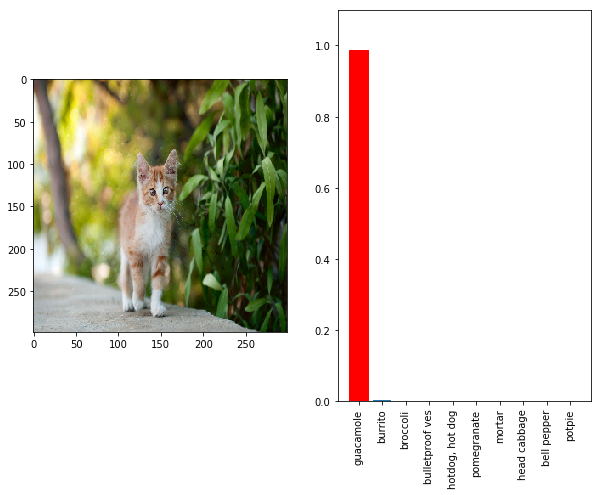

In [15]:
cropped_classify(adv, target_class=TARGET)